# Phase 1 — Setup & Data Preparation

This notebook will:
1. Check Python & packages  
2. Load the dataset  
3. Inspect data (columns, missing values)  
4. Keep only thesis-related columns  
5. Clean invalid/missing values  
6. Save a cleaned CSV for Phase 2


In [1]:
import sys, platform

print("Python:", sys.version)
print("Platform:", platform.platform())

try:
    import pandas as pd, numpy as np
    import matplotlib, sklearn
    print("pandas:", pd.__version__)
    print("numpy:", np.__version__)
    print("matplotlib:", matplotlib.__version__)
    print("scikit-learn:", sklearn.__version__)
except Exception as e:
    print("Some packages are missing:", e)


Python: 3.13.5 (v3.13.5:6cb20a219a8, Jun 11 2025, 12:23:45) [Clang 16.0.0 (clang-1600.0.26.6)]
Platform: macOS-15.3.1-arm64-arm-64bit-Mach-O
pandas: 2.3.2
numpy: 2.3.1
matplotlib: 3.10.6
scikit-learn: 1.7.2


In [7]:
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent          
RAW_CSV_PATH = PROJECT_ROOT / "data" / "mental_health_data final data.csv"
OUTPUT_DIR   = PROJECT_ROOT / "outputs"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

CLEAN_CSV_PATH = OUTPUT_DIR / "mh_lifestyle_phase1_clean.csv"
RAW_CSV_PATH, CLEAN_CSV_PATH


(PosixPath('/Users/rykelle/Documents/GitHub/Thesis/data/mental_health_data final data.csv'),
 PosixPath('/Users/rykelle/Documents/GitHub/Thesis/outputs/mh_lifestyle_phase1_clean.csv'))

In [8]:
import pandas as pd
df = pd.read_csv(RAW_CSV_PATH)
print("Rows x Cols:", df.shape)
df.head(3)


Rows x Cols: (50000, 17)


,User_ID,Age,Gender,Occupation,Country,Mental_Health_Condition,Severity,Consultation_History,Stress_Level,Sleep_Hours,Work_Hours,Physical_Activity_Hours,Social_Media_Usage,Diet_Quality,Smoking_Habit,Alcohol_Consumption,Medication_Usage
0,1,36,Male,Education,Australia,Yes,NaN,Yes,Low,7.6,46,8,2.2,Healthy,Regular Smoker,Regular Drinker,Yes
1,2,48,Male,Engineering,Other,No,Low,No,Low,6.8,74,2,3.4,Unhealthy,Heavy Smoker,Social Drinker,No
2,3,18,Prefer not to say,Sales,India,No,NaN,Yes,Medium,7.1,77,9,5.9,Healthy,Heavy Smoker,Social Drinker,No


In [9]:
# Show all column names
print("Columns:", list(df.columns))

# Show info: number of non-null entries, data types, memory usage
print("\nInfo:")
print(df.info())

# Show missing values count per column (sorted, top 20 only)
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False).head(20))

# Identify columns with text/object data type
non_num_cols = [c for c in df.columns if df[c].dtype == "object"]

# Show sample value counts for first 5 text columns
print("\nSample value counts (first 5 text cols):")
for c in non_num_cols[:5]:
    print(f"\n[{c}]")  # print column name
    print(df[c].value_counts(dropna=False).head(10))  # top 10 most frequent values


Columns: ['User_ID', 'Age', 'Gender', 'Occupation', 'Country', 'Mental_Health_Condition', 'Severity', 'Consultation_History', 'Stress_Level', 'Sleep_Hours', 'Work_Hours', 'Physical_Activity_Hours', 'Social_Media_Usage', 'Diet_Quality', 'Smoking_Habit', 'Alcohol_Consumption', 'Medication_Usage']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   User_ID                  50000 non-null  int64  
 1   Age                      50000 non-null  int64  
 2   Gender                   50000 non-null  object 
 3   Occupation               50000 non-null  object 
 4   Country                  50000 non-null  object 
 5   Mental_Health_Condition  50000 non-null  object 
 6   Severity                 24998 non-null  object 
 7   Consultation_History     50000 non-null  object 
 8   Stress_Level             50000 non-null  ob

In [10]:
# Core lifestyle habits
core_cols = [
    "Sleep_Hours",            # hours of sleep per day
    "Work_Hours",             # hours of work per week
    "Physical_Activity_Hours",# hours of exercise per week
    "Social_Media_Usage",     # hours of social media per day
    "Diet_Quality",           # categorical: Good / Average / Poor
    "Smoking_Habit",          # categorical: Smoker / Non-smoker
    "Alcohol_Consumption",    # categorical: High / Low / None
    "Stress_Level"            # target variable: Low / Medium / High
]

# additional demographics
optional_cols = ["Age", "Gender", "Occupation", "Country"]

# Final list of columns to keep
keep_cols = core_cols + optional_cols

# Filter the dataset to keep only these columns
df_std = df[keep_cols].copy()

print("Columns after filtering:", df_std.columns.tolist())
print("Shape:", df_std.shape)
df_std.head(5)


Columns after filtering: ['Sleep_Hours', 'Work_Hours', 'Physical_Activity_Hours', 'Social_Media_Usage', 'Diet_Quality', 'Smoking_Habit', 'Alcohol_Consumption', 'Stress_Level', 'Age', 'Gender', 'Occupation', 'Country']
Shape: (50000, 12)


,Sleep_Hours,Work_Hours,Physical_Activity_Hours,Social_Media_Usage,Diet_Quality,Smoking_Habit,Alcohol_Consumption,Stress_Level,Age,Gender,Occupation,Country
0,7.6,46,8,2.2,Healthy,Regular Smoker,Regular Drinker,Low,36,Male,Education,Australia
1,6.8,74,2,3.4,Unhealthy,Heavy Smoker,Social Drinker,Low,48,Male,Engineering,Other
2,7.1,77,9,5.9,Healthy,Heavy Smoker,Social Drinker,Medium,18,Prefer not to say,Sales,India
3,6.9,57,4,5.4,Average,Regular Smoker,Regular Drinker,Low,30,Non-binary,Engineering,Australia
4,4.7,45,10,3.3,Unhealthy,Regular Smoker,Non-Drinker,High,58,Male,IT,USA


In [11]:
# Initial cleaning

# 1) Drop rows with missing values in core columns
before = len(df_std)
df_std = df_std.dropna(subset=core_cols)
after = len(df_std)
print(f"Dropped {before - after} rows with missing values. Remaining rows: {after}")

# 2) Convert numeric columns to numbers safely
for c in ["Sleep_Hours", "Work_Hours", "Physical_Activity_Hours", "Social_Media_Usage", "Age"]:
    if c in df_std.columns:
        df_std[c] = pd.to_numeric(df_std[c], errors="coerce")

# 3) Remove impossible ranges
if "Sleep_Hours" in df_std.columns:
    df_std = df_std[df_std["Sleep_Hours"].between(0, 24)]
if "Social_Media_Usage" in df_std.columns:
    df_std = df_std[df_std["Social_Media_Usage"].between(0, 24)]
if "Physical_Activity_Hours" in df_std.columns:
    df_std = df_std[df_std["Physical_Activity_Hours"].between(0, 70)]  # weekly
if "Work_Hours" in df_std.columns:
    df_std = df_std[df_std["Work_Hours"].between(0, 112)]  # weekly

# 4) Standardize Stress_Level labels
df_std["Stress_Level"] = df_std["Stress_Level"].astype(str).str.strip().str.title()

print("Shape after cleaning:", df_std.shape)
df_std.head(5)


Dropped 0 rows with missing values. Remaining rows: 50000
Shape after cleaning: (50000, 12)


,Sleep_Hours,Work_Hours,Physical_Activity_Hours,Social_Media_Usage,Diet_Quality,Smoking_Habit,Alcohol_Consumption,Stress_Level,Age,Gender,Occupation,Country
0,7.6,46,8,2.2,Healthy,Regular Smoker,Regular Drinker,Low,36,Male,Education,Australia
1,6.8,74,2,3.4,Unhealthy,Heavy Smoker,Social Drinker,Low,48,Male,Engineering,Other
2,7.1,77,9,5.9,Healthy,Heavy Smoker,Social Drinker,Medium,18,Prefer not to say,Sales,India
3,6.9,57,4,5.4,Average,Regular Smoker,Regular Drinker,Low,30,Non-binary,Engineering,Australia
4,4.7,45,10,3.3,Unhealthy,Regular Smoker,Non-Drinker,High,58,Male,IT,USA


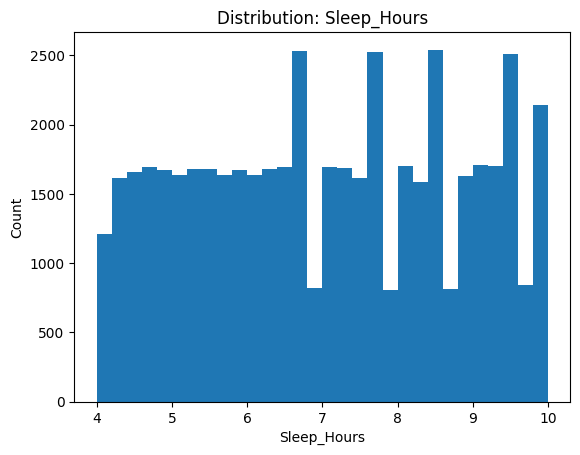

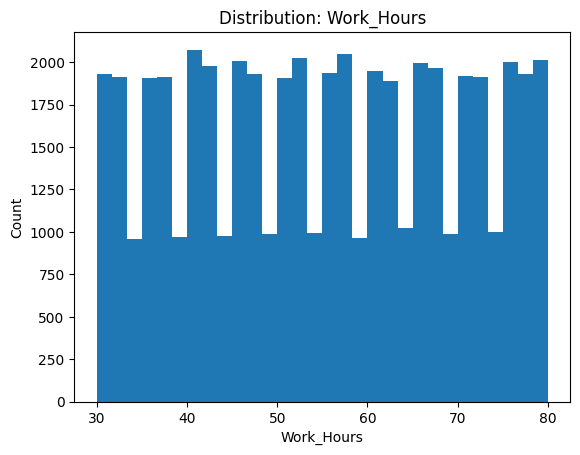

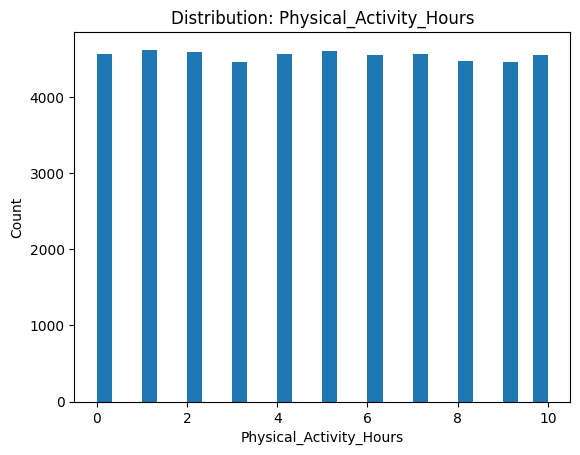

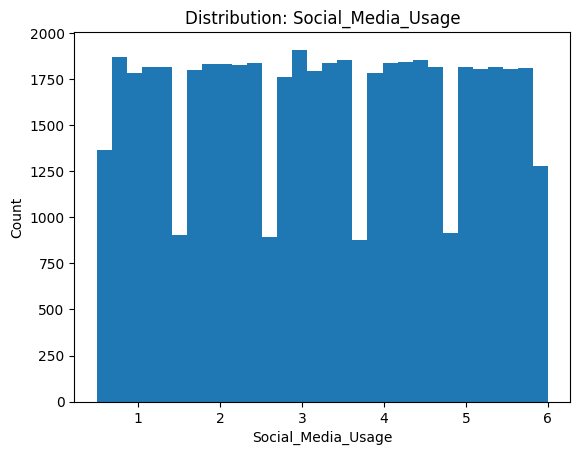

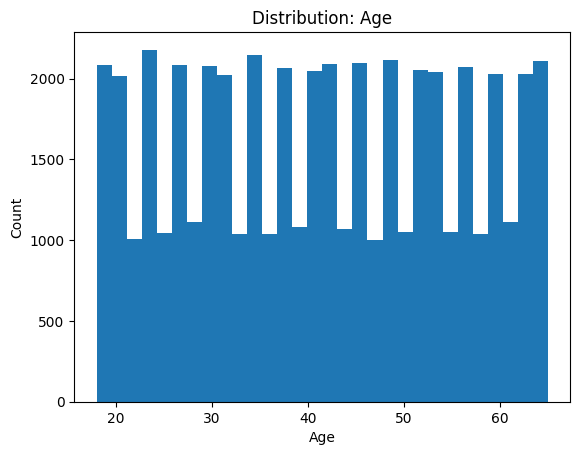

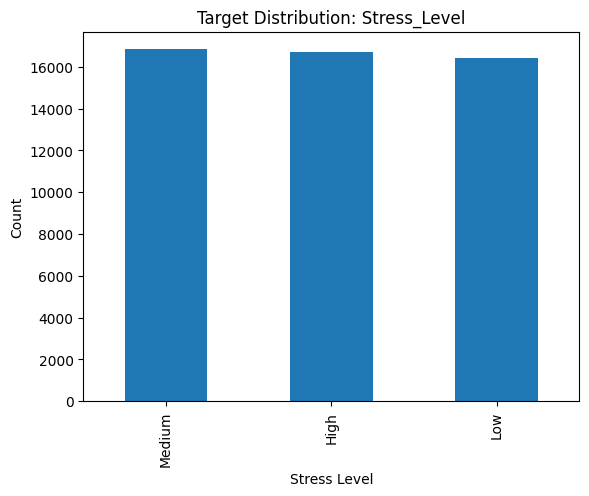

In [12]:
import matplotlib.pyplot as plt

# List of numeric features to visualize
num_cols = ["Sleep_Hours", "Work_Hours", "Physical_Activity_Hours", "Social_Media_Usage", "Age"]

# Histograms for numeric features
for c in num_cols:
    if c in df_std.columns:
        df_std[c].plot(kind="hist", bins=30, title=f"Distribution: {c}")
        plt.xlabel(c)
        plt.ylabel("Count")
        plt.show()

# Bar chart for Stress Level target distribution
df_std["Stress_Level"].value_counts().plot(kind="bar", title="Target Distribution: Stress_Level")
plt.xlabel("Stress Level")
plt.ylabel("Count")
plt.show()


In [13]:
#Save cleaned dataset
df_std.to_csv(CLEAN_CSV_PATH, index=False)
print("✅ Phase 1 complete — cleaned data saved to:", CLEAN_CSV_PATH.resolve())


✅ Phase 1 complete — cleaned data saved to: /Users/rykelle/Documents/GitHub/Thesis/outputs/mh_lifestyle_phase1_clean.csv
